In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import matplotlib.pyplot as plt
import librosa.display

import numpy as np
import pandas as pd
import librosa
import os

import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
input_folder_path = "/content/drive/MyDrive/1_Audio_Preprocessing/1.3_Length_normalized_outputs_in_batches/batch_5"
output_folder_path = "/content/drive/MyDrive/CNN/batch_5"

os.makedirs(output_folder_path, exist_ok=True)

for folder in os.listdir(input_folder_path):
    input_path = os.path.join(input_folder_path, folder)
    output_path = os.path.join(output_folder_path, folder)
    os.makedirs(output_path, exist_ok=True)
    print(f"Folder created at: {output_path}")

    for filename in os.listdir(input_path):
        if filename.endswith('.wav'):
          input_file_path = os.path.join(input_path, filename)
          output_file_path = os.path.join(output_path, os.path.splitext(filename)[0] + '.png')  # Save as .png

          sr=None
          y, sr = librosa.load(input_file_path, sr=sr)
          y = y[8000:16000]
          #print(f"SR : {sr}")

          window_size = 1024
          window = np.hanning(window_size)
          stft = librosa.stft(y, n_fft=window_size, hop_length=512, window=window)
          out = 2 * np.abs(stft) / np.sum(window)

          from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

          fig = plt.Figure()
          canvas = FigureCanvas(fig)
          ax = fig.add_subplot(111)

          p = librosa.display.specshow(librosa.amplitude_to_db(out, ref=np.max),sr=sr, ax=ax, y_axis='log', x_axis='time')

          ax.axis('off')

          fig.savefig(output_file_path, bbox_inches='tight', pad_inches=0)

    print(f"Spectrogram of 0.5s audio saved to {folder}.")


Folder created at: /content/drive/MyDrive/CNN/batch_5/DWmlpyg93YCXAXgE
Spectrogram of 0.5s audio saved to DWmlpyg93YCXAXgE.
Folder created at: /content/drive/MyDrive/CNN/batch_5/g2dnA9Wpvzi2WAmZ
Spectrogram of 0.5s audio saved to g2dnA9Wpvzi2WAmZ.
Folder created at: /content/drive/MyDrive/CNN/batch_5/eL2w4ZBD7liA85wm
Spectrogram of 0.5s audio saved to eL2w4ZBD7liA85wm.
Folder created at: /content/drive/MyDrive/CNN/batch_5/G3QxQd7qGRuXAZda


MODEL 1


📦 Training on batch 1/4: /content/drive/MyDrive/CNN/batch_1
✅ Sample loaded image shape: (95, 128, 1)
Epoch 1/5
1010/1010 [==============================] - 140s 135ms/step - loss: 0.0252 - mae: 0.0853
Epoch 2/5
1010/1010 [==============================] - 130s 129ms/step - loss: 3.0118e-04 - mae: 0.0120
Epoch 3/5
1010/1010 [==============================] - 131s 129ms/step - loss: 8.5447e-05 - mae: 0.0064
Epoch 4/5
1010/1010 [==============================] - 133s 132ms/step - loss: 3.9918e-05 - mae: 0.0042
Epoch 5/5
1010/1010 [==============================] - 130s 129ms/step - loss: 1.8999e-05 - mae: 0.0029
✅ Model saved after batch 1 to /content/drive/MyDrive/CNN/cnn_one_class_model_4.keras

📦 Training on batch 2/4: /content/drive/MyDrive/CNN/batch_2
✅ Sample loaded image shape: (95, 128, 1)
Epoch 1/5
1421/1421 [==============================] - 189s 132ms/step - loss: 8.6681e-06 - mae: 0.0019
Epoch 2/5
1421/1421 [==============================] - 181s 127ms/step - loss: 3.8467e-0

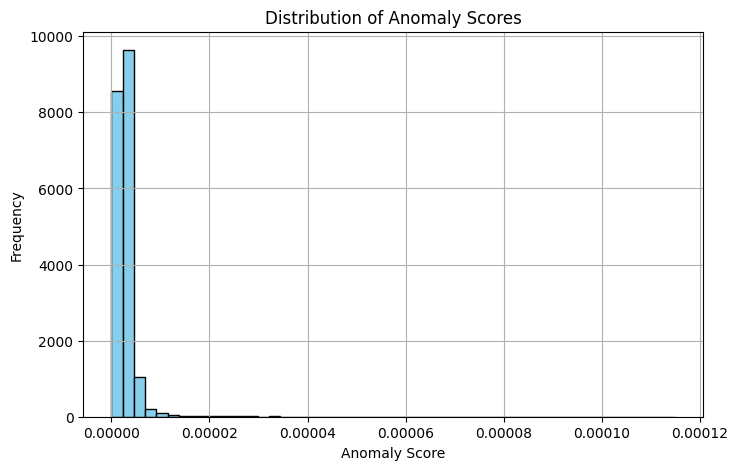


🚨 Anomaly Threshold Set at 97th Percentile: 0.0000
✅ Anomaly threshold saved to /content/drive/MyDrive/CNN/anomaly_threshold.pkl


In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import models, layers
from PIL import Image
import pickle
import matplotlib.pyplot as plt

# ============== CONFIGURATION ==============
main_directory = "/content/drive/MyDrive/CNN"
target_size = (128, 95)  # width=128, height=95 for PIL
batch_size = 4
epochs = 5
model_save_path = "/content/drive/MyDrive/CNN/cnn_one_class_model_4.keras"
threshold_save_path = "/content/drive/MyDrive/CNN/anomaly_threshold.pkl"
scores_save_path = "/content/drive/MyDrive/CNN/anomaly_scores.npy"

# ============== FUNCTION TO LOAD DATA ==============
def load_data_from_batch(batch_path, target_size):
    images = []
    for subfolder in os.listdir(batch_path):
        subfolder_path = os.path.join(batch_path, subfolder)
        if os.path.isdir(subfolder_path):
            for filename in os.listdir(subfolder_path):
                if filename.endswith('.png'):
                    img_path = os.path.join(subfolder_path, filename)
                    img = Image.open(img_path).convert('L')
                    img = img.resize(target_size)  # (width, height) → (128, 95)
                    images.append(np.array(img))
    images = np.array(images) / 255.0
    images = np.expand_dims(images, axis=-1)

    if len(images) > 0:
        print("✅ Sample loaded image shape:", images[0].shape)  # Should be (95, 128, 1)

    return images

# ============== BUILD THE MODEL ==============
def build_one_class_model():
    model = models.Sequential([
        layers.Input(shape=(95, 128, 1)),  # height=95, width=128
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.2),

        layers.GlobalAveragePooling2D(),
        layers.Dense(128, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),

        layers.Dense(1, activation='sigmoid')
    ])
    return model

# ============== TRAIN THE MODEL ==============
model = build_one_class_model()
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

batch_folders = sorted([
    os.path.join(main_directory, batch) for batch in os.listdir(main_directory)
    if os.path.isdir(os.path.join(main_directory, batch)) and batch.startswith("batch")
])

if not batch_folders:
    raise ValueError("No batch folders found in the directory!")

for i, batch_path in enumerate(batch_folders):
    print(f"\n📦 Training on batch {i+1}/{len(batch_folders)}: {batch_path}")
    train_data = load_data_from_batch(batch_path, target_size)

    if len(train_data) == 0:
        print(f"⚠️ Warning: No spectrograms found in {batch_path}, skipping.")
        continue

    history = model.fit(train_data, np.zeros(len(train_data)), epochs=epochs, batch_size=batch_size)
    model.save(model_save_path)
    print(f"✅ Model saved after batch {i+1} to {model_save_path}")

print("\n🎉 Training complete! Final model saved.")

# ============== COMPUTE ANOMALY THRESHOLD ==============
print("\n🔍 Computing anomaly threshold using normal training data...")

all_scores = []
for batch_path in batch_folders:
    batch_data = load_data_from_batch(batch_path, target_size)
    if len(batch_data) == 0:
        continue
    scores = model.predict(batch_data).flatten()
    all_scores.extend(scores)

# Save and analyze scores
all_scores = np.array(all_scores)
np.save(scores_save_path, all_scores)
print(f"💾 Anomaly scores saved to: {scores_save_path}")

# Plot histogram of anomaly scores
plt.figure(figsize=(8, 5))
plt.hist(all_scores, bins=50, color='skyblue', edgecolor='black')
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Set threshold using 97th percentile
anomaly_threshold = np.percentile(all_scores, 97)
print(f"\n🚨 Anomaly Threshold Set at 97th Percentile: {anomaly_threshold:.4f}")

# Save threshold
with open(threshold_save_path, 'wb') as f:
    pickle.dump(anomaly_threshold, f)
print(f"✅ Anomaly threshold saved to {threshold_save_path}")


In [ ]:
import numpy as np
import pickle

# ==== CONFIGURATION ====
input_scores_path = "/content/drive/MyDrive/CNN/anomaly_scores.npy"  # Path to your saved scores
output_threshold_path = "/content/drive/MyDrive/CNN/anomaly_threshold.pkl"  # Where to save 99th percentile

# ==== LOAD SCORES ====
scores = np.load(input_scores_path)
print(f"✅ Loaded {len(scores)} scores from: {input_scores_path}")

# ==== CALCULATE 99th PERCENTILE ====
threshold_99 = np.percentile(scores, 35)
print(f"📌 99th Percentile Threshold: {threshold_99:.6f}")


# ==== SAVE TO PKL FILE ====
with open(output_threshold_path, 'wb') as f:
    pickle.dump(threshold_99, f)

print(f"✅ Threshold saved to: {output_threshold_path}")


✅ Loaded 19730 scores from: /content/drive/MyDrive/CNN/anomaly_scores.npy
📌 99th Percentile Threshold: 0.000002
Test
📌 99th Percentile Print Threshold: 0.000011
✅ Threshold saved to: /content/drive/MyDrive/CNN/anomaly_threshold.pkl


📌 Loading trained model...
✅ Model loaded successfully.

📌 Loading anomaly threshold...
✅ Loaded Anomaly Threshold: 0.000002

📌 Loading test dataset...
✅ Loaded 230 test samples.

📌 Running model predictions on test data...
8/8 [==============================] - 2s 231ms/step
✅ Predictions completed.


<ipython-input-14-2d1fd9656b3e>:78: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


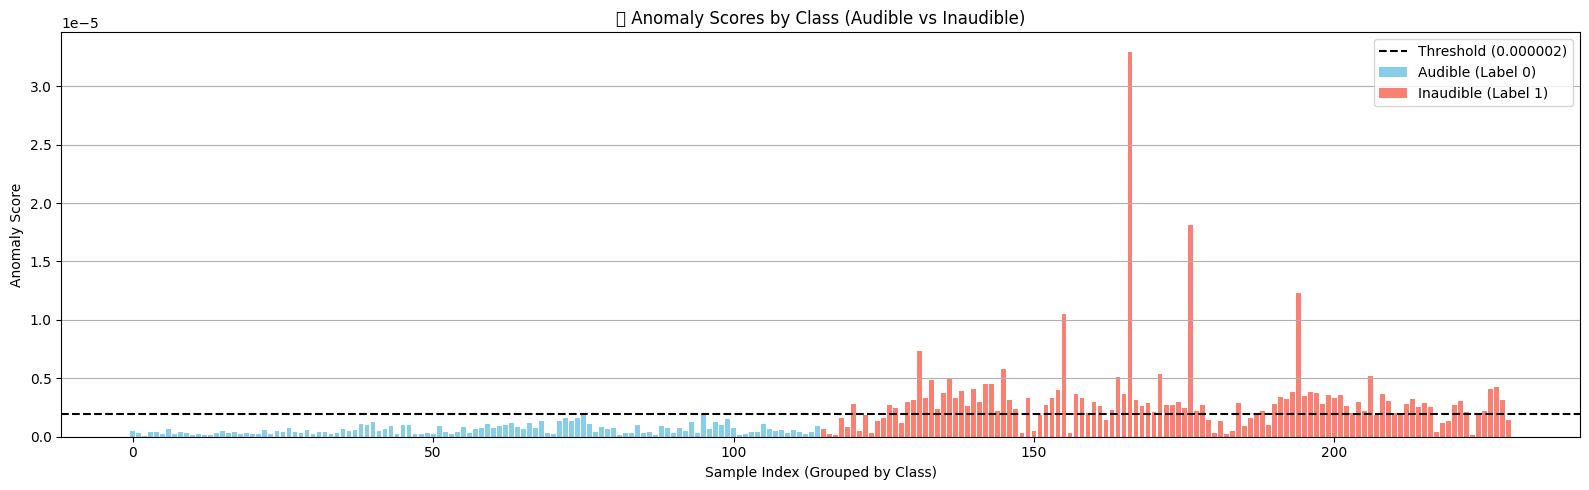

✅ Predictions saved to: /content/drive/MyDrive/CNN/predictions_5.csv

🔹 Model Performance:
📌 Accuracy: 0.8522
📌 Precision: 0.9880
📌 Recall: 0.7130
📌 F1-Score: 0.8283


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


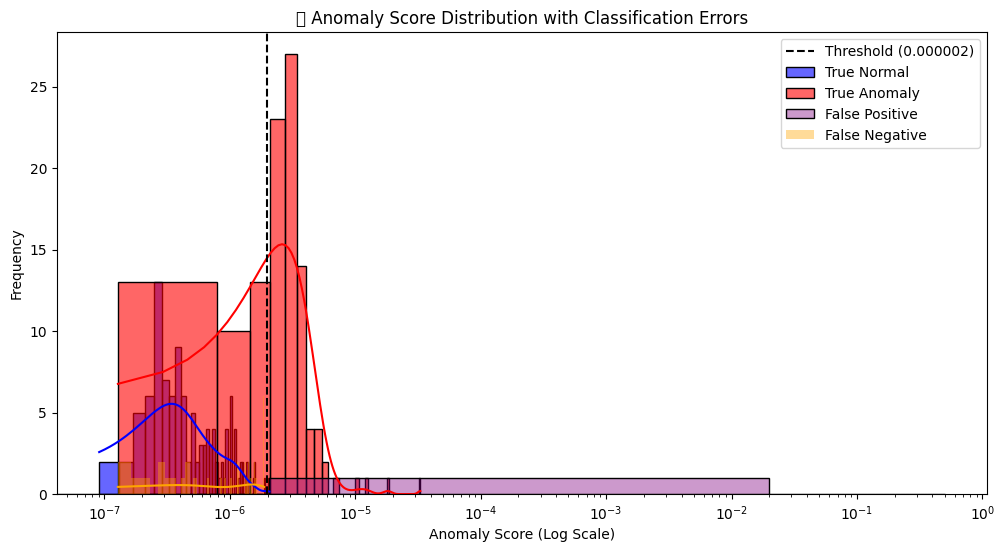

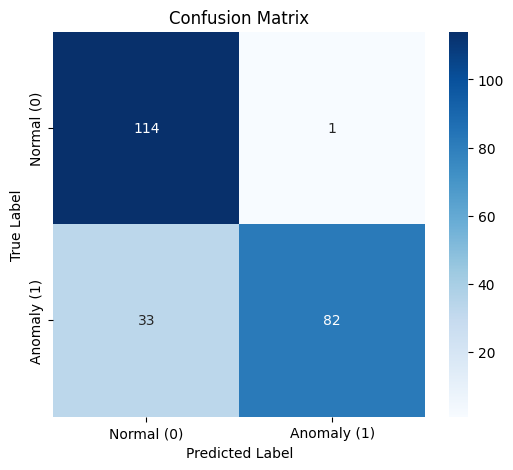


🎉 Testing Complete!


In [ ]:
# ===================== IMPORT LIBRARIES =====================
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Use TensorFlow's Keras loader to avoid deserialization errors
load_model = tf.keras.models.load_model

# ===================== CONFIGURATION =====================
model_path = "/content/drive/MyDrive/CNN/cnn_one_class_model_4.keras"
test_csv_path = "/content/drive/MyDrive/CNN/test_data_labels.csv"
threshold_save_path = "/content/drive/MyDrive/CNN/anomaly_threshold.pkl"
output_csv_path = "/content/drive/MyDrive/CNN/predictions_5.csv"
target_size = (128, 95)  # (width, height) for OpenCV

# ===================== LOAD TRAINED MODEL =====================
print("📌 Loading trained model...")
model = load_model(model_path)
print("✅ Model loaded successfully.")

# ===================== LOAD SAVED ANOMALY THRESHOLD =====================
print("\n📌 Loading anomaly threshold...")
with open(threshold_save_path, 'rb') as f:
    anomaly_threshold = pickle.load(f)
print(f"✅ Loaded Anomaly Threshold: {anomaly_threshold:.6f}")

# ===================== LOAD TEST DATA =====================
print("\n📌 Loading test dataset...")
test_df = pd.read_csv(test_csv_path)  # CSV should have 'image_path' & 'label'
print(f"✅ Loaded {len(test_df)} test samples.")

# ===================== IMAGE LOADING FUNCTION =====================
def load_image(image_path, target_size):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, target_size)  # OpenCV uses (width, height)
    image = image / 255.0
    return np.expand_dims(image, axis=-1)

# Load all test images
X_test = np.array([load_image(img, target_size) for img in test_df["image_path"]])
y_true = test_df["label"].values

# ===================== PREDICT ANOMALY SCORES =====================
print("\n📌 Running model predictions on test data...")
y_pred_scores = model.predict(X_test).flatten()
print("✅ Predictions completed.")


# ===================== BAR CHART: ANOMALY SCORES BY CLASS =====================
plt.figure(figsize=(16, 5))

# Separate indices by class
audible_scores = y_pred_scores[y_true == 0]
inaudible_scores = y_pred_scores[y_true == 1]

# Build x-axis positions
audible_x = np.arange(len(audible_scores))
inaudible_x = np.arange(len(inaudible_scores)) + len(audible_scores)

# Bar chart
plt.bar(audible_x, audible_scores, color='skyblue', label="Audible (Label 0)")
plt.bar(inaudible_x, inaudible_scores, color='salmon', label="Inaudible (Label 1)")

# Threshold line
plt.axhline(y=anomaly_threshold, color='black', linestyle='--', label=f"Threshold ({anomaly_threshold:.6f})")

# Axis labels and ticks
plt.xlabel("Sample Index (Grouped by Class)")
plt.ylabel("Anomaly Score")
plt.title("🔊 Anomaly Scores by Class (Audible vs Inaudible)")
plt.legend()
plt.tight_layout()
plt.grid(axis='y')
plt.show()


# ===================== APPLY THRESHOLD =====================
y_pred_binary = (y_pred_scores > anomaly_threshold).astype(int)

# Save predictions
test_df["predicted_score"] = y_pred_scores
test_df["predicted_label"] = y_pred_binary
test_df.to_csv(output_csv_path, index=False)
print(f"✅ Predictions saved to: {output_csv_path}")

# ===================== METRICS =====================
accuracy = accuracy_score(y_true, y_pred_binary)
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

print(f"\n🔹 Model Performance:")
print(f"📌 Accuracy: {accuracy:.4f}")
print(f"📌 Precision: {precision:.4f}")
print(f"📌 Recall: {recall:.4f}")
print(f"📌 F1-Score: {f1:.4f}")

# ===================== SCORE DISTRIBUTION PLOT =====================
plt.figure(figsize=(12, 6))
sns.histplot(y_pred_scores[y_true == 0], bins=50, color='blue', label="True Normal", alpha=0.6, kde=True)
sns.histplot(y_pred_scores[y_true == 1], bins=50, color='red', label="True Anomaly", alpha=0.6, kde=True)
sns.histplot(y_pred_scores[(y_pred_binary == 1) & (y_true == 0)], bins=50, color='purple', label="False Positive", alpha=0.4, kde=True)
sns.histplot(y_pred_scores[(y_pred_binary == 0) & (y_true == 1)], bins=50, color='orange', label="False Negative", alpha=0.4, kde=True)
plt.axvline(x=anomaly_threshold, color='black', linestyle='dashed', label=f"Threshold ({anomaly_threshold:.6f})")
plt.xlabel("Anomaly Score (Log Scale)")
plt.ylabel("Frequency")
plt.title("🔍 Anomaly Score Distribution with Classification Errors")
plt.xscale("log")
plt.legend()
plt.show()

# ===================== CONFUSION MATRIX =====================
conf_matrix = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Normal (0)", "Anomaly (1)"],
            yticklabels=["Normal (0)", "Anomaly (1)"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

print("\n🎉 Testing Complete!")
